# Kapitel 7: Neuronale Netzwerke - Bilderkennung

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
colors = 'bwr'#['b','y','r']
CMAP = colors#plt.cm.rainbow

In [5]:
from distutils.version import StrictVersion

In [6]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.1.0


In [8]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.0')

Using TensorFlow backend.


2.0.8


In [9]:
import pandas as pd
print(pd.__version__)

assert StrictVersion(pd.__version__) >= StrictVersion('0.19.0')

0.19.2


## Laden und Vorbereiten der Bild-Daten

In [10]:
# !curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
# from zipfile import ZipFile
# zip = ZipFile(r'speed-limit-signs.zip')
# zip.extractall('.')

In [11]:
!ls -l speed-limit-signs

total 0
drwxr-xr-x 2 nbuser nbuser   0 Feb 25 10:58 0
drwxr-xr-x 2 nbuser nbuser   0 Feb 25 10:58 1
drwxr-xr-x 2 nbuser nbuser   0 Feb 25 10:59 2
drwxr-xr-x 2 nbuser nbuser   0 Feb 25 10:59 3
drwxr-xr-x 2 nbuser nbuser   0 Feb 25 10:59 4
drwxr-xr-x 2 nbuser nbuser   0 Feb 25 11:00 5
-rw-r--r-- 1 nbuser nbuser 380 Feb 25 11:00 README.md


In [12]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [13]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [14]:
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

In [15]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

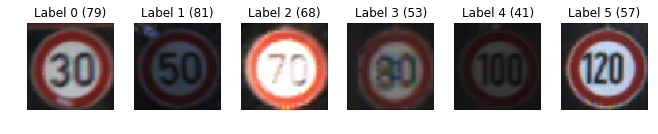

In [16]:
display_images_and_labels(images, labels)
# plt.savefig('ML_0708_signs.png', bbox_inches='tight')

## Modell-Architektur

In [17]:
y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [18]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [19]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
__________

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Zuerst testen wir unser Modell, ob wir es überhaupt trainiert bekommen, indem wir auf einer kleinen Menge von Daten overfitten

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [22]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [25]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Train on 25 samples, validate on 12 samples
Epoch 1/100
25/25 [==============================] - 10s - loss: 1.7914 - acc: 0.1600 - val_loss: 1.6810 - val_acc: 0.3333
Epoch 2/100
25/25 [==============================] - 6s - loss: 1.7292 - acc: 0.2000 - val_loss: 2.0791 - val_acc: 0.3333
Epoch 3/100
25/25 [==============================] - 6s - loss: 2.1041 - acc: 0.2400 - val_loss: 2.3033 - val_acc: 0.1667
Epoch 4/100
25/25 [==============================] - 6s - loss: 1.8668 - acc: 0.2400 - val_loss: 1.9815 - val_acc: 0.1667
Epoch 5/100
25/25 [==============================] - 6s - loss: 1.7936 - acc: 0.2800 - val_loss: 1.8417 - val_acc: 0.0833
Epoch 6/100
25/25 [==============================] - 6s - loss: 1.7724 - acc: 0.2400 - val_loss: 1.8171 - val_acc: 0.0833
Epoch 7/100
25/25 [==============================] - 7s - loss: 1.7648 - acc: 0.2000 - val_loss: 1.8140 - val_acc: 0.0833
Epoch 8/100
25/25 [==============================] - 8s - loss: 1.7442 - acc: 0.2000 - val_loss: 1.79

25/25 [==============================] - 8s - loss: 0.0565 - acc: 1.0000 - val_loss: 3.1824 - val_acc: 0.2500
Epoch 68/100
25/25 [==============================] - 7s - loss: 0.0544 - acc: 1.0000 - val_loss: 2.7026 - val_acc: 0.2500
Epoch 69/100
25/25 [==============================] - 7s - loss: 0.0454 - acc: 1.0000 - val_loss: 2.9703 - val_acc: 0.2500
Epoch 70/100
25/25 [==============================] - 6s - loss: 0.0340 - acc: 1.0000 - val_loss: 3.6364 - val_acc: 0.2500
Epoch 71/100
25/25 [==============================] - 7s - loss: 0.0253 - acc: 1.0000 - val_loss: 4.3475 - val_acc: 0.2500
Epoch 72/100
25/25 [==============================] - 8s - loss: 0.0203 - acc: 1.0000 - val_loss: 4.6875 - val_acc: 0.2500
Epoch 73/100
25/25 [==============================] - 8s - loss: 0.0169 - acc: 1.0000 - val_loss: 5.0146 - val_acc: 0.3333
Epoch 74/100
25/25 [==============================] - 7s - loss: 0.0151 - acc: 1.0000 - val_loss: 5.1751 - val_acc: 0.3333
Epoch 75/100
25/25 [=========

## Das sieht gut aus, nun versuchen wir es mit dem kompletten Datensatz ohne Overfitting und mit Dropout

In [23]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [24]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# wenn die Ergebnisse lange Zeit schlecht bleiben, brechen wir lieber ab
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1)

In [ ]:
# only for local gpu on windows

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [28]:
# Das kann auf Azure wirklich lange dauern, 100 Epochen ist eigentlich zu wenig, für ein gute Ergebnis
# jede Epoche kann bis zu einer Minute dauern, das hier also immer noch 100 Minuten
# auf einer guten GPU dauern 500 Epochen eher 4-5 Minuten
# BATCH_SIZE = 500
BATCH_SIZE = 32
%time model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping_callback])

Train on 242 samples, validate on 61 samples
Epoch 1/100
242/242 [==============================] - 60s - loss: 1.9361 - acc: 0.1860 - val_loss: 1.7942 - val_acc: 0.1639
Epoch 2/100
242/242 [==============================] - 60s - loss: 1.7885 - acc: 0.1983 - val_loss: 1.7943 - val_acc: 0.1639
Epoch 3/100
242/242 [==============================] - 61s - loss: 1.7782 - acc: 0.2273 - val_loss: 1.7840 - val_acc: 0.1639
Epoch 4/100
242/242 [==============================] - 58s - loss: 1.7604 - acc: 0.1901 - val_loss: 1.7793 - val_acc: 0.2295
Epoch 5/100
242/242 [==============================] - 57s - loss: 1.7509 - acc: 0.2479 - val_loss: 1.7774 - val_acc: 0.2295
Epoch 6/100
242/242 [==============================] - 57s - loss: 1.7637 - acc: 0.2727 - val_loss: 1.7863 - val_acc: 0.1639
Epoch 7/100
242/242 [==============================] - 59s - loss: 1.7225 - acc: 0.2397 - val_loss: 1.7258 - val_acc: 0.2295
Epoch 8/100
242/242 [==============================] - 58s - loss: 1.7174 - acc:

242/242 [==============================] - 59s - loss: 0.3479 - acc: 0.8719 - val_loss: 0.5067 - val_acc: 0.9180
Epoch 66/100
242/242 [==============================] - 60s - loss: 0.3430 - acc: 0.8926 - val_loss: 0.2695 - val_acc: 0.9016
Epoch 67/100
242/242 [==============================] - 59s - loss: 0.5210 - acc: 0.8306 - val_loss: 0.5821 - val_acc: 0.7541
Epoch 68/100
242/242 [==============================] - 58s - loss: 0.4494 - acc: 0.8471 - val_loss: 0.3380 - val_acc: 0.8689
Epoch 69/100
242/242 [==============================] - 58s - loss: 0.2034 - acc: 0.9421 - val_loss: 0.2376 - val_acc: 0.9508
Epoch 70/100
242/242 [==============================] - 59s - loss: 0.3037 - acc: 0.9132 - val_loss: 0.2179 - val_acc: 0.9344
Epoch 71/100
242/242 [==============================] - 60s - loss: 0.1889 - acc: 0.9421 - val_loss: 0.3214 - val_acc: 0.9180
Epoch 72/100
242/242 [==============================] - 60s - loss: 0.2512 - acc: 0.9298 - val_loss: 0.3751 - val_acc: 0.9344
Epoch

# Bewertung

In [29]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 23s    


(0.074855730381698987, 0.99009901009770507)

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 5s     


(0.10514919708580955, 0.94736842105263153)

# Sichern des Modells

In [31]:
!rm -r models
!mkdir models

rm: cannot remove 'models': No such file or directory


In [32]:
model.save('models/conv-vgg.hdf5')

In [33]:
!ls -lh models

total 0
-rw-r--r-- 1 nbuser nbuser 55M Feb 25 13:21 conv-vgg.hdf5


In [34]:
# !curl --upload-file ./models/conv-vgg.hdf5 https://transfer.sh/conv-vgg.hdf5

# Ausprobieren auf ein paar Test-Daten

In [35]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([2, 2, 0, 1, 1, 5, 2, 2, 5, 2])

In [36]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

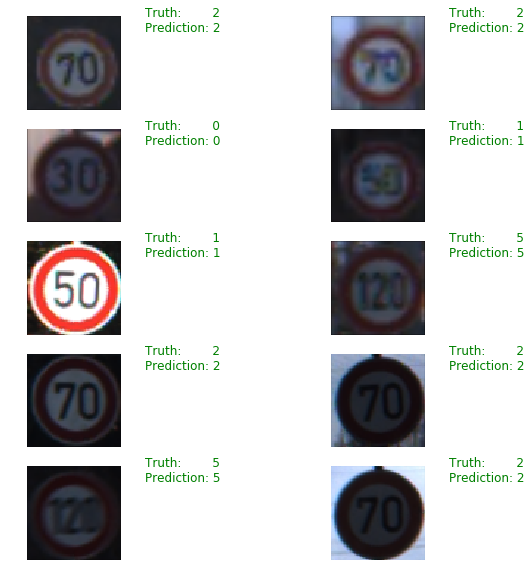

In [37]:
display_prediction(sample_images, ground_truth, predicted_categories)